In [1]:

import cv2, vpi
import torch
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

from torchvision.io import read_image, ImageReadMode
from torchvision.transforms.v2.functional import perspective

import kornia.geometry.transform as K

from scipy.ndimage import affine_transform

/home/zh/.local/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_validation.py:114: UserWarning: WARNING: failed to get cudart_version from onnxruntime build info.
  warnings.warn("WARNING: failed to get cudart_version from onnxruntime build info.")


(-0.5, 1919.5, 1199.5, -0.5)

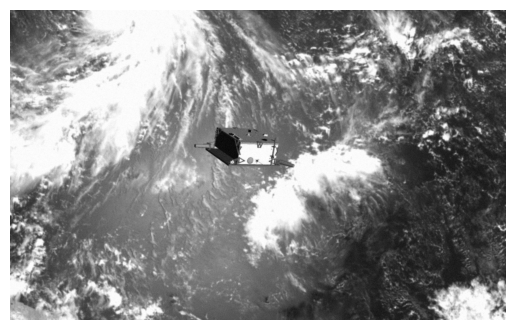

In [2]:
image_cv = cv2.imread('img008549.jpg')
# 用plotlib显示原图
plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
plt.axis('off')

In [3]:
warp_matrix = np.array([[1, 0, 50], [0, 1, 50], [0, 0, 1]], dtype=np.float32)

In [6]:
%%timeit global image_cv_repeat
cv2.warpPerspective(image_cv, warp_matrix, (image_cv.shape[1], image_cv.shape[0]))

1.55 ms ± 23 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


(-0.5, 1919.5, 1199.5, -0.5)

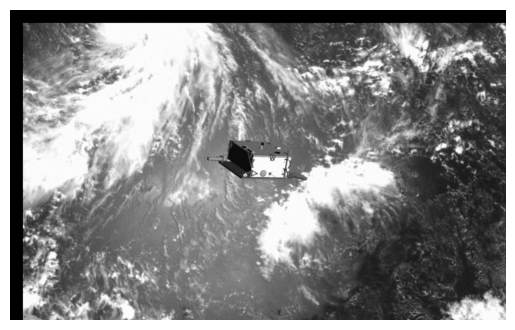

In [5]:
# 用plotlib显示原图
image_cv = cv2.warpPerspective(image_cv, warp_matrix, (image_cv.shape[1], image_cv.shape[0]))
plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
plt.axis('off')

In [6]:
with vpi.Backend.CUDA:
    image_cuda = vpi.asimage(image_cv).convert(vpi.Format.NV12_ER)

In [17]:
%%timeit global image_cv
with vpi.Backend.CUDA:
    image_cuda.perspwarp(warp_matrix)

81.7 µs ± 886 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
with vpi.Backend.CUDA:
    image_cuda = image_cuda.perspwarp(warp_matrix)
with image_cuda.rlock_cpu() as Data:
    image_0 = Data[0]
    image_1 = Data[1]
print(image_0.shape, image_1.shape)

(1200, 1920) (600, 960, 2)


(-0.5, 1919.5, 1199.5, -0.5)

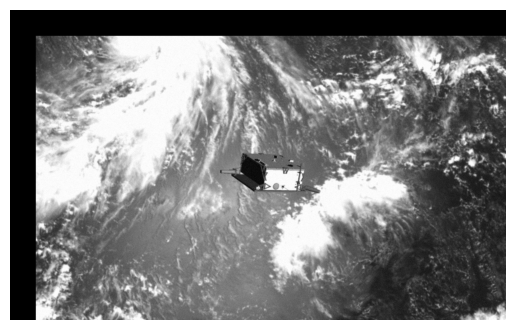

In [8]:
plt.imshow(cv2.cvtColor(image_0, cv2.COLOR_GRAY2RGB))
plt.axis('off')

In [3]:
image_tensor = read_image('img008549.jpg', ImageReadMode.GRAY)
M_tensor = torch.from_numpy(warp_matrix).float()
image_tensor = image_tensor.to("cuda")
image_tensor

tensor([[[ 80,  78,  88,  ...,  51,  60,  58],
         [ 82,  85,  84,  ...,  44,  43,  51],
         [ 78,  84,  76,  ...,  49,  45,  53],
         ...,
         [202, 194, 191,  ..., 246, 255, 252],
         [204, 199, 203,  ..., 245, 255, 255],
         [207, 197, 194,  ..., 254, 252, 244]]], device='cuda:0',
       dtype=torch.uint8)

In [4]:
startpoints = [[0, 0], [0, 100], [100, 0], [100, 100]]
endpoints = [[0, 0], [0, 200], [200, 0], [200, 200]]

In [8]:
%%timeit -r 10 -n 30  global image_tensor
perspective(image_tensor.unsqueeze(0), coefficients=[1, 2, 4, 5, 4, 3, 0, 0])

2.77 ms ± 87.7 µs per loop (mean ± std. dev. of 10 runs, 30 loops each)


In [23]:
image_tensor = read_image('img008549.jpg', ImageReadMode.GRAY).float().to("cuda")
M_tensor = torch.from_numpy(warp_matrix).float().to("cuda")

In [24]:
%%timeit global image_tensor
K.warp_perspective(image_tensor.unsqueeze(0), M_tensor.unsqueeze(0), dsize=(image_tensor.shape[1], image_tensor.shape[2]))

3.86 ms ± 35 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [3]:
image_sk = cv2.imread('img008549.jpg')

In [4]:
from skimage.transform import warp

In [6]:
%%timeit global image_sk
warp(image_sk, warp_matrix)

123 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
image_skl = cv2.imread('img008549.jpg')

In [8]:
%%timeit global image_skl
affine_transform(image_skl, warp_matrix)

1.57 s ± 39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
